In [21]:
from pathlib import Path
from datetime import datetime
import numpy as np
import pandas as pd
import joblib

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# ----- paths (same layout as earlier) -----
ROOT    = Path.cwd().parents[0]
DATA    = ROOT / "data" / "processed"
MODELS  = ROOT / "models"
MODELS.mkdir(parents=True, exist_ok=True)

ART_DIR = DATA
TARGET  = "co2_fixation_g_l_day"   # keep consistent with EDA/preproc


In [22]:
def load_y(path):
    # Works whether your CSV has a header or not
    s = pd.read_csv(path, header=None).iloc[:, 0]
    s = pd.to_numeric(s, errors="coerce")   # coerce bad strings to NaN
    return s.values

y_train = load_y(ART_DIR / "y_train.csv")
y_test  = load_y(ART_DIR / "y_test.csv")

In [23]:
import numpy as np

print("X_train:", X_train.shape, "X_test:", X_test.shape)
print("y_train:", y_train.shape, "y_test:", y_test.shape)

print("NaNs in y_train:", int(np.isnan(y_train).sum()))
print("NaNs in y_test :", int(np.isnan(y_test).sum()))

# X, y
X_train = np.load(ART_DIR / "X_train_proc.npy")
X_test  = np.load(ART_DIR / "X_test_proc.npy")

y_train = pd.read_csv(ART_DIR / "y_train.csv").squeeze("columns").values
y_test  = pd.read_csv(ART_DIR / "y_test.csv").squeeze("columns").values

# Optional: these are handy for feature importance and inference
preprocess = joblib.load(ART_DIR / "preprocess_pipeline.joblib")
features   = pd.read_csv(ART_DIR / "features_used.csv", header=None).iloc[:,0].tolist()

X_train.shape, X_test.shape, y_train.shape, y_test.shape, len(features)

X_train: (230, 10) X_test: (66, 10)
y_train: (233,) y_test: (65,)
NaNs in y_train: 1
NaNs in y_test : 1


((232, 10), (64, 10), (232,), (64,), 10)

In [24]:
# Clean y_train / X_train
mask_tr = np.isfinite(y_train)
if mask_tr.sum() != len(mask_tr):
    print(f"[info] Dropping {len(mask_tr) - mask_tr.sum()} train rows with NaN/inf in y.")
    X_train = X_train[mask_tr]
    y_train = y_train[mask_tr]

# Clean y_test / X_test (not strictly required for fit, but good for metrics)
mask_te = np.isfinite(y_test)
if mask_te.sum() != len(mask_te):
    print(f"[info] Dropping {len(mask_te) - mask_te.sum()} test rows with NaN/inf in y.")
    X_test = X_test[mask_te]
    y_test = y_test[mask_te]

X_train.shape, X_test.shape, y_train.shape, y_test.shape


((232, 10), (64, 10), (232,), (64,))

In [25]:
rf = RandomForestRegressor(
    n_estimators=400,
    max_depth=None,
    random_state=42,
    n_jobs=-1,
)
rf.fit(X_train, y_train)


,n_estimators,400
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [26]:
y_pred = rf.predict(X_test)

# Handle older scikit-learn that doesn’t accept squared=False
try:
    rmse = mean_squared_error(y_test, y_pred, squared=False)
except TypeError:
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

mae = mean_absolute_error(y_test, y_pred)
r2  = r2_score(y_test, y_pred)

print(f"Baseline RMSE : {rmse:.4f}")
print(f"Baseline MAE  : {mae:.4f}")
print(f"Baseline R²   : {r2:.4f}")


Baseline RMSE : 0.0027
Baseline MAE  : 0.0019
Baseline R²   : 0.9997


In [27]:
stamp = datetime.now().strftime("%Y%m%d_%H%M%S")
model_path = MODELS / f"baseline_randomforest_{stamp}.joblib"
joblib.dump(rf, model_path)

# Feature importances → map to 'features_used.csv' order
if hasattr(rf, "feature_importances_"):
    fi = pd.DataFrame({
        "feature": features,
        "importance": rf.feature_importances_
    }).sort_values("importance", ascending=False)
    fi.to_csv(ART_DIR / "feature_importance_baseline.csv", index=False)
    display(fi.head(10))

model_path


,feature,importance
9,growth_rate,0.999236
3,ph_before_injection,0.000124
4,ph_after_injection,0.000100
2,light_intensity_umol_m2_s1,0.000095
5,do_mg_l,0.000092
1,air_temp_c,0.000084
8,dry_weight_g_l,0.000084
7,optical_density,0.000067
6,salinity_psu,0.000065
0,day_index,0.000054


WindowsPath('D:/6 Project/ZeroAlgae/Research/carbon-fixation-ml-starter/models/baseline_randomforest_20250815_165559.joblib')

In [28]:
pd.DataFrame({
    "y_true": y_test,
    "y_pred": y_pred
}).to_csv(ART_DIR / f"predictions_baseline_{stamp}.csv", index=False)


In [29]:
# Load raw cleaned dataset (same one used in preprocessing)
raw = pd.read_csv(ART_DIR / "microalgae_dataset_clean.csv", sep=";", encoding="utf-8-sig")

# Keep only the training features (same order)
X_raw = raw[features].copy()

# Use the saved pipeline to transform
X_raw_proc = preprocess.transform(X_raw)

# Load the just-saved model and predict a few rows
model = joblib.load(model_path)
sample_idx = np.arange(min(5, len(raw)))
raw_preds = model.predict(X_raw_proc[sample_idx])

preview = raw.loc[sample_idx, features].copy()
preview[TARGET] = raw.loc[sample_idx, TARGET] if TARGET in raw.columns else np.nan
preview["predicted_" + TARGET] = raw_preds
preview


,day_index,air_temp_c,light_intensity_umol_m2_s1,ph_before_injection,ph_after_injection,do_mg_l,salinity_psu,optical_density,dry_weight_g_l,growth_rate,co2_fixation_g_l_day,predicted_co2_fixation_g_l_day
0,1.0,28.2,108.01,8.11,8.02,3.86,33.0,0.1500,0.000000e+00,0.000000,0.000000,0.000073
1,2.0,28.0,104.65,8.14,8.07,4.00,31.0,0.1660,7.000000e-07,0.000001,0.000001,0.000022
2,3.0,26.5,106.83,8.21,8.01,4.30,35.0,0.1680,2.180000e-05,0.000021,0.000039,0.000125
3,4.0,25.7,100.97,8.25,8.08,4.26,29.0,0.1950,3.134000e-04,0.000292,0.000534,0.000696
4,5.0,25.4,104.97,8.25,8.07,4.04,30.0,0.1859,2.510100e-03,0.002197,0.004020,0.004006


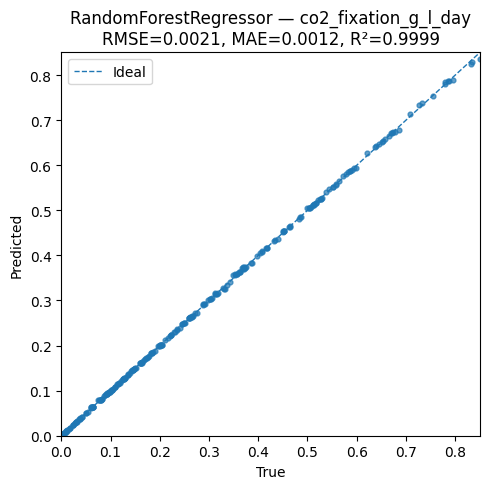

Saved:
 - data\processed\predictions_baseline_20250815_170217.csv
 - models\baseline_metrics_20250815_170217.txt
 - models\feature_importances_20250815_170217.csv
 - models\pred_vs_true_20250815_170217.png


In [30]:
# --- Wrap-up: save predictions, metrics, feature importances, and a plot ---

from pathlib import Path
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

stamp = datetime.now().strftime("%Y%m%d_%H%M%S")

DATA_OUT   = Path("data/processed")
MODELS_OUT = Path("models")
DATA_OUT.mkdir(parents=True, exist_ok=True)
MODELS_OUT.mkdir(parents=True, exist_ok=True)

# 1) Make predictions for ALL rows we loaded in `raw` (already used above)
#    X_raw_proc and `model` are already defined in your notebook.
y_pred_full = model.predict(X_raw_proc)

# If the target column exists in raw, compute metrics on rows that have labels.
if TARGET in raw.columns:
    y_true = raw[TARGET].values
    mask = ~pd.isna(y_true)

    # Try modern RMSE; fall back for older sklearn if needed
    try:
        rmse = mean_squared_error(y_true[mask], y_pred_full[mask], squared=False)
    except TypeError:
        rmse = np.sqrt(mean_squared_error(y_true[mask], y_pred_full[mask]))

    mae = mean_absolute_error(y_true[mask], y_pred_full[mask])
    r2  = r2_score(y_true[mask], y_pred_full[mask])
else:
    y_true = np.full(len(raw), np.nan)
    rmse = mae = r2 = np.nan

# 2) Save full predictions CSV (keep the original columns + prediction)
pred_df = raw.copy()
pred_df[f"pred_{TARGET}"] = y_pred_full
pred_csv = DATA_OUT / f"predictions_baseline_{stamp}.csv"
pred_df.to_csv(pred_csv, index=False)

# 3) Save metrics + feature importances
metrics_txt = MODELS_OUT / f"baseline_metrics_{stamp}.txt"
with open(metrics_txt, "w") as f:
    f.write(f"Target: {TARGET}\n")
    f.write(f"RMSE : {rmse:.6f}\n")
    f.write(f"MAE  : {mae:.6f}\n")
    f.write(f"R^2  : {r2:.6f}\n")
    f.write(f"Rows : {len(raw)}\n")

# Feature importances (works for tree models like RandomForest/XGBoost)
try:
    fi = pd.Series(model.feature_importances_, index=features).sort_values(ascending=False)
    fi_path = MODELS_OUT / f"feature_importances_{stamp}.csv"
    fi.to_csv(fi_path, header=["importance"])
except AttributeError:
    # Model may not expose `feature_importances_`; that's fine.
    pass

# 4) Quick plot: predicted vs. true (only where y_true exists)
if np.isfinite(rmse):
    plt.figure(figsize=(5,5))
    plt.scatter(y_true[mask], y_pred_full[mask], s=12, alpha=0.7)
    lims = [
        min(y_true[mask].min(), y_pred_full[mask].min()),
        max(y_true[mask].max(), y_pred_full[mask].max())
    ]
    plt.plot(lims, lims, "--", lw=1, label="Ideal")
    plt.xlim(lims); plt.ylim(lims)
    plt.xlabel("True"); plt.ylabel("Predicted")
    plt.title(f"{type(model).__name__} — {TARGET}\nRMSE={rmse:.4f}, MAE={mae:.4f}, R²={r2:.4f}")
    plt.legend()
    fig_path = MODELS_OUT / f"pred_vs_true_{stamp}.png"
    plt.tight_layout()
    plt.savefig(fig_path, dpi=150)
    plt.show()

print("Saved:")
print(" -", pred_csv)
print(" -", metrics_txt)
try:
    print(" -", fi_path)
    print(" -", fig_path)
except NameError:
    pass
